<a href="https://colab.research.google.com/github/avrland/News-predict-word-count/blob/main/WordCountPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Count Predict
## About this notebook
It's regression model trying to predict word count of news title from characters count. 
As data source we use [polishNewsTitleDatabase](https://github.com/avrland/polishNewsTitleDatabase), my scrapped base of over 100k news titles from polish sites.


# Getting and preparing data

In [47]:
!pip install wget
import wget
import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import RANSACRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download data to local, show first lines and database size.

In [13]:
def lineCounter(filename):
  file = open(filename, "r")
  line_count = 0
  for line in file:
      if line != "\n":
          line_count += 1
  return str(line_count)

url = 'https://raw.githubusercontent.com/avrland/polishNewsTitleDatabase/main/titles.txt'
filename = '/content/titles.txt'  
wget.download(url, filename)
with open(filename) as fn:  
  ln = fn.readline()
  lncnt = 0
  while lncnt < 5:
       print("Line {}: {}".format(lncnt, ln.strip()))
       ln = fn.readline()
       lncnt += 1
print(f"Database size: {lineCounter(filename)}")

Line 0: Polka straciła 36 tys. zł: napastnik wykiwał zarówno ją jak i bank
Line 1: Chrome 86 na Androida pozwoli zaplanować pobieranie. Można już testować
Line 2: Poczta Polska i cyfrowa rewolucja. Identyfikacja RFID przyspieszy wysyłki
Line 3: GOG GALAXY 2.0 łączy siły z Epic Games Store. Jest wreszcie oficjalna integracja
Line 4: Android Auto ma problem – miesza okładki odtwarzanych albumów
Database size: 114952


Putting our data to pandas dataframe.

In [22]:
cols = ['titles']
data = pd.read_csv(r"titles.txt", header=None, names=cols)

## Gathering stats from raw data
Calculating char and word amount for every line, put it into separate dataframe, then show it on boxplot chart.

[]

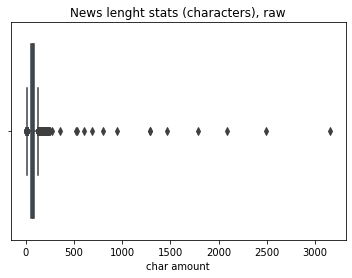

In [23]:
char_lenghts = []
for x in range(len(data)):
    z = len(data.iloc[x,0])
    char_lenghts.append(z)
pd_char_lenghts = pd.DataFrame(char_lenghts)
pd_char_lenghts.columns = ['char amount']

plt.figure()
sns.boxplot(x=pd_char_lenghts.iloc[:,0]).set(title='News lenght stats (characters), raw')
plt.plot()

[]

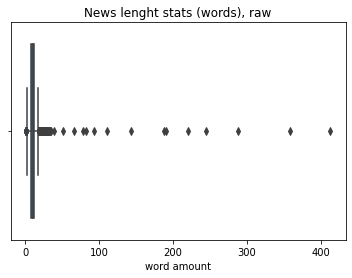

In [6]:
word_amount = []
for x in range(len(data)):
    sentence = data.iloc[x,0]
    words = len(sentence.split())
    word_amount.append(words)
pd_word_amount = pd.DataFrame(word_amount)
pd_word_amount.columns = ['word amount']

plt.figure()
sns.boxplot(x=pd_word_amount.iloc[:,0]).set(title='News lenght stats (words), raw')
plt.plot()

## Getting rid of outliers (characters)
As there are outliers, we're getting rid of them by IQR method. Let's start from character count. We're showing cleaned data in boxplot here too. We can read here that mean of words is 72.

Chars mean: 72


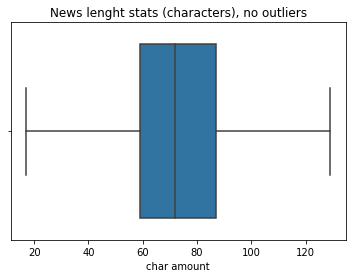

In [41]:
Q1 = pd_char_lenghts.quantile(0.25) 
Q3 = pd_char_lenghts.quantile(0.75)
IQR = Q3 - Q1

outlier_condition = ((pd_char_lenghts < (Q1 - 1.5 * IQR)) | (pd_char_lenghts > (Q3 +1.5 * IQR)))
pd_char_lenghts_IQR = pd_char_lenghts[~outlier_condition.any(axis=1)]
plt.figure()
sns.boxplot(x=pd_char_lenghts_IQR.iloc[:,0]).set(title='News lenght stats (characters), no outliers')
plt.plot()
print(f"Chars mean: {int(pd_char_lenghts_IQR.mean())}")

We're printing some of outliers.

In [30]:
char_outliers_count = len(pd_char_lenghts) - len(pd_char_lenghts_IQR)
print(f"char outliers count: {char_outliers_count}")
char_outliers_indexes = pd_char_lenghts.drop(index=pd_char_lenghts_IQR.index)
char_outliers = data.iloc[char_outliers_indexes.index, :]
print(char_outliers.iloc[:10, :])

char outliers count: 1315
                                                                                                                                         titles
175                                                                                                                                  ​Pęknięcie
177                                                                                                                                  Cofamy się
179                                                                                                                                   Neutralni
558                                                                                                                                  Arab Blues
1333    Rząd wypowie Konwencję stambulską? Aktywistki: Polki nie mogą liczyć na wsparcie ze strony państwa. System jest dziurawy i nieefektywny
1661                                                                                                          

## Getting rid of outliers (words)
As there are outliers also here, we're getting rid of them by IQR method. We're showing cleaned data here in boxplot too. We can read here that mean of words is 10.

Words mean: 10


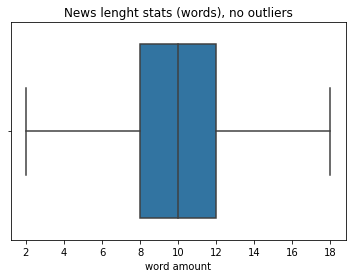

In [40]:
Q1 = pd_word_amount.quantile(0.25) 
Q3 = pd_word_amount.quantile(0.75)
IQR = Q3 - Q1

outlier_condition = ((pd_word_amount < (Q1 - 1.5 * IQR)) | (pd_word_amount > (Q3 +1.5 * IQR)))
pd_word_amount_IQR = pd_word_amount[~outlier_condition.any(axis=1)]

plt.figure()
sns.boxplot(x=pd_word_amount_IQR.iloc[:,0]).set(title='News lenght stats (words), no outliers')
plt.plot()
print(f"Words mean: {int(pd_word_amount.mean())}")

In [35]:
word_outliers_count = len(pd_word_amount) - len(pd_word_amount_IQR)
print(f"word outliers count: {word_outliers_count}")
word_outliers_indexes = pd_word_amount.drop(index=pd_word_amount_IQR.index)
word_outliers = data.iloc[word_outliers_indexes.index, :]
print(word_outliers.iloc[:10, :])

word outliers count: 1691
                                                                                                                                       titles
175                                                                                                                                ​Pęknięcie
179                                                                                                                                 Neutralni
847          Solidarna Polska o praworządności: Niepokoi nas to iż w tej sprawie inny komunikat płynie ze strony przewodniczącego RE [WYWIAD]
1333  Rząd wypowie Konwencję stambulską? Aktywistki: Polki nie mogą liczyć na wsparcie ze strony państwa. System jest dziurawy i nieefektywny
1361                            Dane z MF: W cztery miesiące fiskus rozłożył na raty 12 mld zł podatków. To blisko 2 razy więcej niż rok temu
1369                                   Orban mówi wprost, że 30 lat temu myśmy pukali do drzwi Europy, a teraz to Europa p

## Data linking
Forming a relationship between word and char amount. I'm doing the same steps as in separate words/characters chapters.


Text(0, 0.5, 'words')

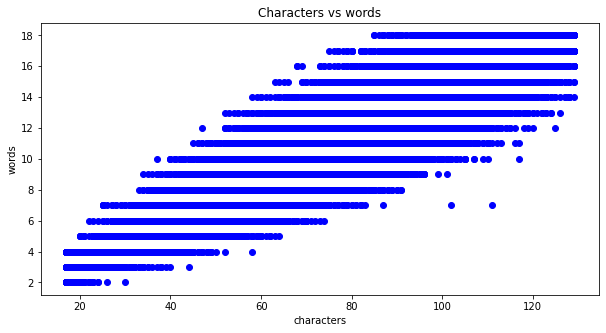

In [42]:
titles_stats = pd.concat([pd_char_lenghts, pd_word_amount], axis = 1)
Q1 = titles_stats.quantile(0.25) 
Q3 = titles_stats.quantile(0.75)
IQR = Q3 - Q1

outlier_condition = ((titles_stats < (Q1 - 1.5 * IQR)) | (titles_stats > (Q3 +1.5 * IQR)))
titles_stats_IQR = titles_stats[~outlier_condition.any(axis=1)]

X = np.array(titles_stats_IQR['word amount']).reshape(-1,1)
y = np.array(titles_stats_IQR['char amount']).reshape(-1,1)
plt.figure(figsize=(10,5))
plt.scatter(y, X, color = 'blue')
plt.title("Characters vs words")
plt.xlabel("characters")
plt.ylabel("words")

# Division into training and test sets

Let char amount be X, and word amount be y. I scale data on X'es. Test size is 20% of whole data.

In [104]:
X = np.array(titles_stats_IQR['char amount']).reshape(-1,1)
y = np.array(titles_stats_IQR['word amount']).reshape(-1,1)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Training linear regression
I'm using simply LinearRegression and draw it on my data.

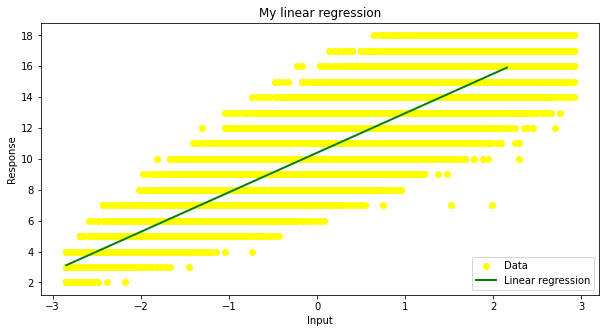

Linear regression R2 result: 0.7744495018509545
Linear regression score: 77.44%


In [105]:
lr = LinearRegression()
lr.fit(X_train, y_train)
r2_lr = r2_score(y_test, lr.predict(X_test))

line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y_lr = lr.predict(line_X)
plt.figure(figsize=(10,5))
 
plt.scatter(X, y, color = 'yellow', label = 'Data')
plt.plot(line_X, line_y_lr, color='green', linewidth=2, label='Linear regression')
 
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.title("My linear regression")
plt.show()
print("Linear regression R2 result: {}".format(r2_lr))
score = round(lr.score(X_test, y_test)*100,2)
print(f"Linear regression score: {score}%")

Result is not crazy, but probably on that kind of data we won't get better. If I'm wrong, let me know :)

## Predicting, comparing to real values
You can enter your news title and try to predict word count here:

In [108]:
# make a prediction using a scalar value
title_to_predict_wordcount = "Ze smartfonami jest jeszcze gorzej, ni\u017C my\u015Bleli\u015Bmy" #@param {type:"string"}
word_count_real = len(title_to_predict_wordcount.split())
char_len = len(title_to_predict_wordcount)
char_len_scaled = scaler.transform(np.array(char_len).reshape(1,-1))
word_count_prediction = round(int(lr.predict(char_len_scaled)))
print(f"Entered title: {title_to_predict_wordcount}")
print(f"Entered titles has: {char_len} characters")
print(f"Model predicted: {word_count_prediction} words")
print(f"Real count: {word_count_real} words")
error = ((word_count_real - word_count_prediction)/word_count_real)*100
print(f"Error rate: {round(error,2)}%")

Entered title: Ze smartfonami jest jeszcze gorzej, niż myśleliśmy
Entered titles has: 50 characters
Model predicted: 7 words
Real count: 7 words
Error rate: 0.0%
